## Preface
I listen to a lot of metal and arguably listen to too much music. Just getting this out of the way before we proceed to the data. 

So if you're not comfortable with religious or morbid themes appearing in band, album , or track names, then I would not recommened reading this post.

In [1]:
import json 
import os
import csv 
import time
import datetime as dt
import calendar
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from spotipy.oauth2 import SpotifyOAuth
import spotipy as spot

## Create a dataframe with 2025 data 
First we create a loop to interate through all of the files in our directory of Spotify data. 

Note, we have our python / ipython file in the directory with all of our Spotify Json files.

In [2]:
folder_path = "." #current directory 
dfs = [] 


for filename in os.listdir(folder_path):
    file_ext = os.path.splitext(filename)[1] #extract file extension
    if file_ext == '.json': 
        with open (filename,'r') as f: 
            data = json.load(f)
            dfs.append(pd.DataFrame(data)) #add to the list of intermediary dataframes
    else: 
        pass 

df = pd.concat(dfs, ignore_index = True) #combines all of the dataframes in our list 

df.drop("ip_addr", axis = 1 , inplace = True) # remove the IP address column 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52451 entries, 0 to 52450
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   ts                                 52451 non-null  object
 1   platform                           52451 non-null  object
 2   ms_played                          52451 non-null  int64 
 3   conn_country                       52451 non-null  object
 4   master_metadata_track_name         52381 non-null  object
 5   master_metadata_album_artist_name  52381 non-null  object
 6   master_metadata_album_album_name   52381 non-null  object
 7   spotify_track_uri                  52381 non-null  object
 8   episode_name                       70 non-null     object
 9   episode_show_name                  70 non-null     object
 10  spotify_episode_uri                70 non-null     object
 11  audiobook_title                    0 non-null      object
 12  audi

## Dataframe Modifications 
We will explore the content of our dataframe and remove any irrelevant features 

In [37]:
df["ts"] = pd.to_datetime(df["ts"], utc=True)
df = df.sort_values("ts" , ignore_index=True)
df.head()

,ts,track_name,artist_name,album_name,spotify_track_uri,genre,album_art_url,season
0,2025-01-01 02:27:17+00:00,Appreciation,Benji Blue Bills,Campaign Blue,spotify:track:19O5wyExKoHwZxbhFXMO2d,rage rap,NaN,Winter
1,2025-01-01 02:30:24+00:00,Spaced Out,Young Nudy,Slimeball,spotify:track:4y3l1Qk130C1ebtgIGxltq,rap,NaN,Winter
2,2025-01-01 02:32:29+00:00,TIFFANY,Benji Blue Bills,TIFFANY,spotify:track:0ckMp5ZvtSgFQkzXpyqLKA,rage rap,NaN,Winter
3,2025-01-01 02:34:07+00:00,5unna,Homixide Gang,Snotty World (Deluxe),spotify:track:2M1LHRfp0vsJKjKfKxOUx3,rage rap,NaN,Winter
4,2025-01-01 02:35:35+00:00,Santal 33,Benji Blue Bills,500k Degrees,spotify:track:3uHVUXDiDnMoatRNlpNFHd,rage rap,NaN,Winter


### Filter for 2025 only 


In [8]:
df = df[df["ts"].dt.year == 2025] # keep only rows where the year is 2025
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37265 entries, 15186 to 52450
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   ts                                 37265 non-null  datetime64[ns, UTC]
 1   platform                           37265 non-null  object             
 2   ms_played                          37265 non-null  int64              
 3   conn_country                       37265 non-null  object             
 4   master_metadata_track_name         37196 non-null  object             
 5   master_metadata_album_artist_name  37196 non-null  object             
 6   master_metadata_album_album_name   37196 non-null  object             
 7   spotify_track_uri                  37196 non-null  object             
 8   episode_name                       69 non-null     object             
 9   episode_show_name                  69 non-null     

In [9]:
df["reason_end"].value_counts()

reason_end
trackdone                       22749
endplay                          8258
fwdbtn                           3080
logout                           1936
remote                            563
unexpected-exit-while-paused      348
backbtn                           245
unexpected-exit                    58
unknown                            15
trackerror                         13
Name: count, dtype: int64

In [10]:
df["skipped"].value_counts()

skipped
False    25682
True     11583
Name: count, dtype: int64

In [11]:
reasons = []

for x in range(0,len(data)) : 
    reasons.append(data[x].get("reason_end")) 

reasons_list = set(reasons) 
print(reasons_list)

{'endplay', 'fwdbtn', 'unexpected-exit', 'unknown', 'logout', 'unexpected-exit-while-paused', 'backbtn', 'trackdone', 'trackerror', 'remote'}


We looked through a json file instead of the dataframe itself simply because the JSON file would be quicker to iterate through. Most of the track end reasons that we would need should be contained in every single Json file. 

With the reasons in hand. We will only consider rows with `'trackdone'` as it's `reason_end` entry to be a complete listen of a track. Any other reasons will not be considered.

It seems that all rows with `endplay` have `True` as their value for `skipped`. As the follow snippet returns 8258 rows with **True** as the value and no rows with **False**. 

```python
df.loc[(df["reason_end"] == "endplay") , "skipped"].value_counts()
```

```
skipped
True    8258
Name: count, dtype: int64
```

Therefore we will not be considering those as full listens. 

In [12]:
df.loc[(df["reason_end"] == "endplay") , "skipped"].value_counts()

skipped
True    8258
Name: count, dtype: int64

In [13]:
df.loc[(df["reason_end"] == "trackdone" ), "skipped"].value_counts()

skipped
False    22749
Name: count, dtype: int64

In [14]:
df = df[(df["reason_end"] == "trackdone")]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22749 entries, 15186 to 52449
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   ts                                 22749 non-null  datetime64[ns, UTC]
 1   platform                           22749 non-null  object             
 2   ms_played                          22749 non-null  int64              
 3   conn_country                       22749 non-null  object             
 4   master_metadata_track_name         22748 non-null  object             
 5   master_metadata_album_artist_name  22748 non-null  object             
 6   master_metadata_album_album_name   22748 non-null  object             
 7   spotify_track_uri                  22748 non-null  object             
 8   episode_name                       1 non-null      object             
 9   episode_show_name                  1 non-null      

You can see that we went from 52,451 rows to 22,749 . An $\approx$ 56% reduction in rows. A suprising number of my tracks are not listened to completion. 

---
Amount of rows when we limit rows to "trackdone" OR "endplay" + "skipped == False": $22,749$

Amount of rows when we limit rows to "trackdone" OR endplay: $31,007$

Amount of rows when we limit to just "trackdone"  : $22,749$



### Rename Columns 

In [15]:
master_list = [x for x in df.columns if x.startswith("master_")]
master_list

['master_metadata_track_name',
 'master_metadata_album_artist_name',
 'master_metadata_album_album_name']

I don't like these column names so I will proceed to simplify them. The "master_" prefix may be helpful with tracks that feature more than one artist maybe ? 

In [16]:
for x in master_list:  
    df.rename(columns = {x:"_".join(x.split("_")[-2:])},inplace = True)
df.tail()

,ts,platform,ms_played,conn_country,track_name,artist_name,album_name,spotify_track_uri,episode_name,episode_show_name,...,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
15186,2025-01-01 02:27:17+00:00,ios,252244,US,Appreciation,Benji Blue Bills,Campaign Blue,spotify:track:19O5wyExKoHwZxbhFXMO2d,None,None,...,None,None,None,clickrow,trackdone,False,False,False,1735690003,False
15187,2025-01-01 02:30:24+00:00,ios,189554,US,Spaced Out,Young Nudy,Slimeball,spotify:track:4y3l1Qk130C1ebtgIGxltq,None,None,...,None,None,None,trackdone,trackdone,False,False,False,1735698434,False
15188,2025-01-01 02:32:29+00:00,ios,128760,US,TIFFANY,Benji Blue Bills,TIFFANY,spotify:track:0ckMp5ZvtSgFQkzXpyqLKA,None,None,...,None,None,None,trackdone,trackdone,False,False,False,1735698620,False
15189,2025-01-01 02:34:07+00:00,ios,100414,US,5unna,Homixide Gang,Snotty World (Deluxe),spotify:track:2M1LHRfp0vsJKjKfKxOUx3,None,None,...,None,None,None,trackdone,trackdone,False,False,False,1735698746,False
15190,2025-01-01 02:35:35+00:00,ios,91157,US,Santal 33,Benji Blue Bills,500k Degrees,spotify:track:3uHVUXDiDnMoatRNlpNFHd,None,None,...,None,None,None,trackdone,trackdone,False,False,False,1735698843,False


### Remove unneeded columns

In [17]:
df.columns.tolist()

['ts',
 'platform',
 'ms_played',
 'conn_country',
 'track_name',
 'artist_name',
 'album_name',
 'spotify_track_uri',
 'episode_name',
 'episode_show_name',
 'spotify_episode_uri',
 'audiobook_title',
 'audiobook_uri',
 'audiobook_chapter_uri',
 'audiobook_chapter_title',
 'reason_start',
 'reason_end',
 'shuffle',
 'skipped',
 'offline',
 'offline_timestamp',
 'incognito_mode']

In [18]:
cols = df.columns.tolist()
cols = cols[:1] + cols[4:8]
df = df[cols]
df.tail()

,ts,track_name,artist_name,album_name,spotify_track_uri
52442,2025-10-29 19:11:53+00:00,Crying for Death,Morbid Saint,Spectrum of Death,spotify:track:49vQZiDk1YfTtNb04MY6jr
52444,2025-10-29 19:15:01+00:00,Andanom,Wulkanaz,Wulkanaz,spotify:track:1K2Uu3SUF5ftqxqidoLVEo
52447,2025-10-29 19:28:49+00:00,Crush the Skull,Unleashed,Shadows in the Deep,spotify:track:6DdtUqruR9qAaQY6IU9YG2
52448,2025-10-29 19:33:08+00:00,Bitter Loss,Entombed,Left Hand Path,spotify:track:7cjxGM8tECsRdiTBYc2KFw
52449,2025-10-29 19:36:25+00:00,Into Glory Ride,Unleashed,Where No Life Dwells,spotify:track:7oV7uI6LsjW9dZ0iQWjyE8


### Update the indices on the dataframe to reflect the number of rows

In [19]:
df.head()

,ts,track_name,artist_name,album_name,spotify_track_uri
15186,2025-01-01 02:27:17+00:00,Appreciation,Benji Blue Bills,Campaign Blue,spotify:track:19O5wyExKoHwZxbhFXMO2d
15187,2025-01-01 02:30:24+00:00,Spaced Out,Young Nudy,Slimeball,spotify:track:4y3l1Qk130C1ebtgIGxltq
15188,2025-01-01 02:32:29+00:00,TIFFANY,Benji Blue Bills,TIFFANY,spotify:track:0ckMp5ZvtSgFQkzXpyqLKA
15189,2025-01-01 02:34:07+00:00,5unna,Homixide Gang,Snotty World (Deluxe),spotify:track:2M1LHRfp0vsJKjKfKxOUx3
15190,2025-01-01 02:35:35+00:00,Santal 33,Benji Blue Bills,500k Degrees,spotify:track:3uHVUXDiDnMoatRNlpNFHd


In [344]:
df = df.set_axis(list(range(0,len(df))), axis = 0)
df

,ts,platform,ms_played,conn_country,track_name,artist_name,album_name,spotify_track_uri,episode_name,episode_show_name,...,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2025-01-01 02:27:17+00:00,ios,252244,US,Appreciation,Benji Blue Bills,Campaign Blue,spotify:track:19O5wyExKoHwZxbhFXMO2d,None,None,...,None,None,None,clickrow,trackdone,False,False,False,1735690003,False
1,2025-01-01 02:30:24+00:00,ios,189554,US,Spaced Out,Young Nudy,Slimeball,spotify:track:4y3l1Qk130C1ebtgIGxltq,None,None,...,None,None,None,trackdone,trackdone,False,False,False,1735698434,False
2,2025-01-01 02:32:29+00:00,ios,128760,US,TIFFANY,Benji Blue Bills,TIFFANY,spotify:track:0ckMp5ZvtSgFQkzXpyqLKA,None,None,...,None,None,None,trackdone,trackdone,False,False,False,1735698620,False
3,2025-01-01 02:34:07+00:00,ios,100414,US,5unna,Homixide Gang,Snotty World (Deluxe),spotify:track:2M1LHRfp0vsJKjKfKxOUx3,None,None,...,None,None,None,trackdone,trackdone,False,False,False,1735698746,False
4,2025-01-01 02:35:35+00:00,ios,91157,US,Santal 33,Benji Blue Bills,500k Degrees,spotify:track:3uHVUXDiDnMoatRNlpNFHd,None,None,...,None,None,None,trackdone,trackdone,False,False,False,1735698843,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22744,2025-10-29 19:11:53+00:00,android,262668,US,Crying for Death,Morbid Saint,Spectrum of Death,spotify:track:49vQZiDk1YfTtNb04MY6jr,None,None,...,None,None,None,trackdone,trackdone,False,False,False,1761764709,False
22745,2025-10-29 19:15:01+00:00,android,187565,US,Andanom,Wulkanaz,Wulkanaz,spotify:track:1K2Uu3SUF5ftqxqidoLVEo,None,None,...,None,None,None,clickrow,trackdone,False,False,False,1761765113,False
22746,2025-10-29 19:28:49+00:00,android,216107,US,Crush the Skull,Unleashed,Shadows in the Deep,spotify:track:6DdtUqruR9qAaQY6IU9YG2,None,None,...,None,None,None,fwdbtn,trackdone,False,False,False,1761765916,False
22747,2025-10-29 19:33:08+00:00,android,262760,US,Bitter Loss,Entombed,Left Hand Path,spotify:track:7cjxGM8tECsRdiTBYc2KFw,None,None,...,None,None,None,trackdone,trackdone,False,False,False,1761766127,False


---

In [342]:
artist_set = set(df.artist_name.value_counts().index.tolist())
print(f"Number of unique artists in our dataframe: {len(artist_set)}")

Number of unique artists in our dataframe: 719


---

## Top 10 artists and albums
Here we will create a horizontal bar chart for the top 10 artists. Ranking them by the number of streams. 

In [28]:
top10_artists_listens = df.artist_name.value_counts().nlargest(10)
top10_artists = top10_artists_listens.index

In [29]:
top10_artists

Index(['Departure Chandelier', 'Yeat', 'Armagedda', 'Unleashed', 'Immortal',
       'Darkthrone', 'Dissection', 'Bathory', 'Black Flag', 'Judas Iscariot'],
      dtype='object', name='artist_name')

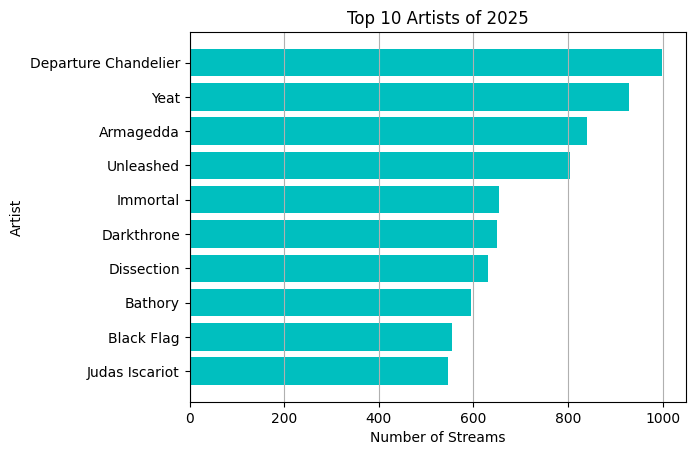

In [36]:
plt.barh(top10_artists, width = top10_artists_listens , color = 'c' , align = 'center') 
plt.grid(axis = "x")
plt.xlabel("Number of Streams")
plt.ylabel("Artist")
plt.title("Top 10 Artists of 2025")
plt.gca().invert_yaxis()
plt.show()

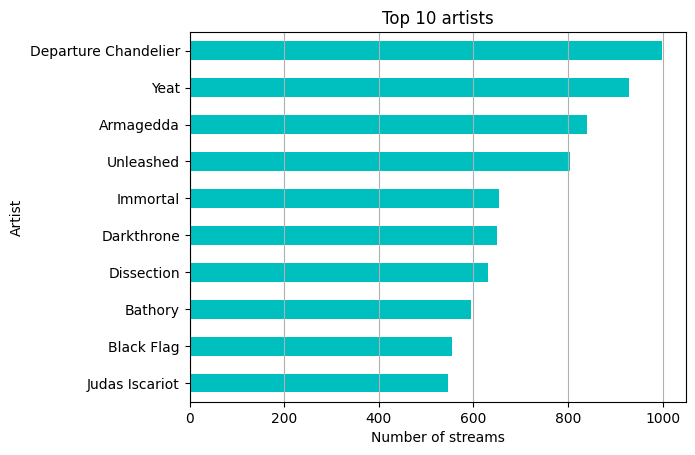

In [23]:
top10_artists = df["artist_name"].value_counts().nlargest(10)

ax = top10_artists.plot(
    kind="barh",
    title="Top 10 artists",
    xlabel="Number of streams",
    ylabel="Artist",
    color="c"
)
ax.grid(axis="x")
ax.invert_yaxis()

In [24]:
top10_albums_listens = df.album_name.value_counts().nlargest(10)
top10_albums = top10_albums_listens.index

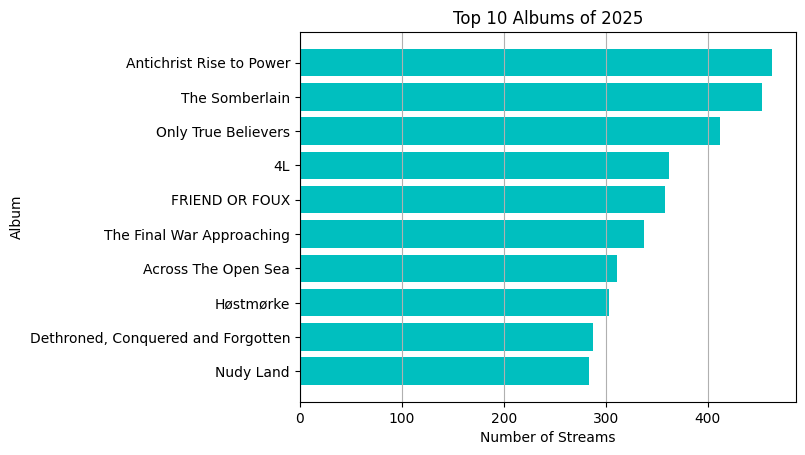

In [25]:
plt.barh(top10_albums, width = top10_albums_listens , color = 'c' )
plt.grid(axis = "x")
plt.xlabel("Number of Streams") 
plt.ylabel("Album") 
plt.title("Top 10 Albums of 2025")
plt.gca().invert_yaxis()
plt.show()

In [26]:
top10_track_listens = df["track_name"].value_counts().nlargest(10)
top10_tracks = top10_track_listens.index 
top10_tracks
top10_track_listens

track_name
Total Death                                         267
Catacombs Beneath the Castle of the Marquis         132
The Black Crest of Death, The Gold Wreath of War    127
Only True Believers                                 117
Journey Through Visions of War                      110
I'm the One                                         108
Equimanthorn                                         99
In the Cold Winds of Nowhere                         98
The Sun No Longer Rises                              97
A Sacrifice to the Corsica Antichrist                96
Name: count, dtype: int64

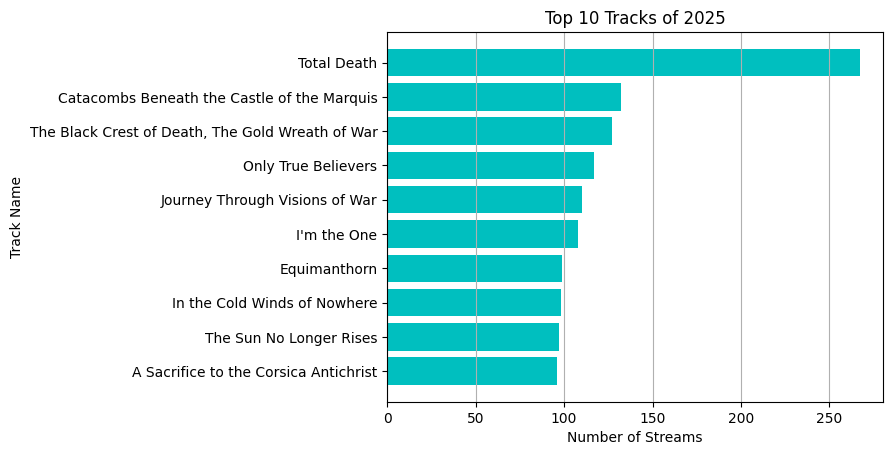

In [27]:
plt.barh(top10_tracks , width = top10_track_listens , color = "c" , align = "center")
plt.grid(axis = "x")
plt.gca().invert_yaxis()
plt.title("Top 10 Tracks of 2025")
plt.xlabel("Number of Streams")
plt.ylabel("Track Name")
plt.show()

## Retrieving Track Genres and Album Art (with Spotipy and the Spotify API)

We will create two new columns in our dataframe. 
* `genre` - contains the first listed genre for a given track
* `album_art` - contains the url to the smallest size available image of the track's album cover. 


In [ ]:
sp = spot.Spotify(auth_manager = SpotifyOAuth(
    client_id = "f6608d55a39c4114bb74f4ed8de67a22",
    client_secret = "a409fd97cf5f432a87c9c4e872253ab5",
    redirect_uri = "http://127.0.0.1:8081/callback"
    
))

In [172]:
artist_list = list(df["artist_name"].unique())
len(artist_list)

720

In [345]:
track = sp.track("spotify:track:7cjxGM8tECsRdiTBYc2KFw")
track

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2pnezMcaiTHfGmgmGQjLsB'},
    'href': 'https://api.spotify.com/v1/artists/2pnezMcaiTHfGmgmGQjLsB',
    'id': '2pnezMcaiTHfGmgmGQjLsB',
    'name': 'Entombed',
    'type': 'artist',
    'uri': 'spotify:artist:2pnezMcaiTHfGmgmGQjLsB'}],
  'available_markets': ['AR',
   'AU',
   'AT',
   'BE',
   'BO',
   'BR',
   'BG',
   'CA',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DK',
   'DO',
   'DE',
   'EC',
   'EE',
   'SV',
   'FI',
   'FR',
   'GR',
   'GT',
   'HN',
   'HK',
   'HU',
   'IS',
   'IE',
   'IT',
   'LV',
   'LT',
   'LU',
   'MY',
   'MT',
   'MX',
   'NL',
   'NZ',
   'NI',
   'NO',
   'PA',
   'PY',
   'PE',
   'PH',
   'PL',
   'PT',
   'SG',
   'SK',
   'ES',
   'SE',
   'CH',
   'TW',
   'TR',
   'UY',
   'US',
   'GB',
   'AD',
   'LI',
   'MC',
   'ID',
   'JP',
   'TH',
   'VN',
   'RO',
   'IL',
   'ZA',
   'SA',
   'AE',
   'BH',
   'QA',
   'OM',
   

There is no mention of a genre in the dictionary for this track. It turns out that genres are associated with the artist and not a given track. Which I guess makes sense and should work for most cases, as I imagine the number of albums with disparate genres between tracks is quite low. 

Let's go about finding the first genre for each artist and add it to a new column in our dataframe called genre. 

#### Limitations with Spotify Web API 

We have a [limited number](https://developer.spotify.com/documentation/web-api/concepts/rate-limits) of API calls that we can make in a 30 second period, so we need to use them wisely. Here is how we will approach retrieving artist genres:

1. Create a list of all artists in the dataframe.
2. Iterate through the artist list.
3. Find the first track in the dataframe for the artist.
4. Retrieve the artist’s genres after retrieving the artist ID (by searching with the track’s URI).
5. Assign the first retrieved genre to all rows for that artist.
6. Repeat for the next artist in the list.

If the data I received from Spotify came with the artist IDs we could have a much simpler approach of searching for genres with the artist ID instead. At least we can use a track URI to retrieve the artist ID (as seen previously with the Entombed example).

### Fetching the genre of my top 10 - 15 artists 

In [159]:
top15_artists_listens = df.artist_name.value_counts().nlargest(15)
top15_artists_list = list(top15_artists_listens.index)
top15_artists_list 

['Departure Chandelier',
 'Yeat',
 'Armagedda',
 'Unleashed',
 'Immortal',
 'Darkthrone',
 'Dissection',
 'Bathory',
 'Black Flag',
 'Judas Iscariot',
 'Young Thug',
 'Lancey Foux',
 'Wagner Ödegård',
 'Benji Blue Bills',
 'Aura Noir']

In [ ]:
def get_track_genres(sp, track_uri): 
    track = sp.track(track_uri)
    artist_id = track['artists'][0]['id']
    artist = sp.artist(artist_id)
    genres = artist.get("genres", [])
    genre = genres[0] if genres else None #return None if no Genres were retrieved
    return genre 


def mass_genre_fetch(sp, artist_list,df): 
    g_dict = dict() 
    
    for x in artist_list : 
        df_artist =  df[df["artist_name"] == x].copy(deep = False) 
        if df_artist.empty:
            continue
        row_0 = next(df_artist.itertuples(index=False))
        genre = get_track_genres(sp, row_0.spotify_track_uri)
        df.loc[df["artist_name"] == x, "genre"] = genre #place the genre in all rows that the artist appears in
        g_dict[x] = genre
    return g_dict 

Return the genres of the top 15 artists. Populate the `df["genre"]` column with thier genres as well. 

In [ ]:
start = time.time()
genre_dictionary = mass_genre_fetch(sp, top15_artists_list , df) 

with open("genres.csv", "w" , newline = "") as f: 
    writer = csv.writer(f) 
    writer.writerow(["Artist","Genre"]) 
    for artist , genre in genre_dictionary.items(): 
        writer.writerow([artist,genre])

end = time.time()

print(f"Duration of genre retrieval and csv creation: {(end - start):.2f}")

Looking at the csv, Benji Blue Bills was the only artist without a genre so I will manually change his to `"rage rap"`. 

In [57]:
df.loc[df["artist_name"] == "Departure Chandelier" , "track_name"].value_counts()

track_name
Catacombs Beneath the Castle of the Marquis                             132
The Black Crest of Death, The Gold Wreath of War                        127
A Sacrifice to the Corsica Antichrist                                    96
By Way of Torchlight from Parliament to Catacombs                        84
Hard as a Coffin Nail                                                    78
Life Escaping Through the Candle's Smoke                                 59
Forever Faithful to the Emperor                                          52
Departure Chandelier                                                     51
Between This World And The Next                                          49
Consecrating the Flame of Resistance                                     37
Re-Establish the Black Rule of France                                    36
Intro (Napoleon's Sword)                                                 31
Intro - Candle Below The Rope                                            23
S

In [75]:
df["genre"].isnull().values.sum()

np.int64(13618)

Let's try getting the genres for the next 20 most common artists and then populate the dataframe rows for the artists with the correct genre. 

In [83]:
top15_to_35_artists_listens = df.artist_name.value_counts()[15:35] 
top15_to_35_artists_list = list(top15_to_35_artists_listens.index)
top15_to_35_artists_list

['Young Nudy',
 'Isengard',
 'Playboi Carti',
 'Abigor',
 'Gehenna',
 'Rostorchester',
 'Ragnarok',
 'Wasted Youth',
 'Real Estate',
 'Beach Fossils',
 'Venusberg Cardinal',
 'Mäleficentt',
 'Ulver',
 'Absu',
 'Angelcorpse',
 'Mystifier',
 'Ken Carson',
 'Maniac Butcher',
 'Convulse',
 'Wulkanaz']

In [84]:
start = time.time()
genre_dictionary = mass_genre_fetch(sp, top15_to_35_artists_list , df) 

with open("genres_artist_15_to_35.csv", "w" , newline = "") as f: 
    writer = csv.writer(f) 
    writer.writerow(["Artist","Genre"]) 
    for artist , genre in genre_dictionary.items(): 
        writer.writerow([artist,genre])

end = time.time()

print(f"Duration of genre retrieval and csv creation: {(end - start):.2f}")

Duration of genre retrieval and csv creation: 5.31


That took 5.31 seconds. 

`Duration of genre retrieval and csv creation: 5.31`

Let's make a loop to iterate through the most common artists , in groups of 20. We'll include a method of handling the case where we hit the API call limit. 

In [87]:
top50_artists_listens = df.artist_name.value_counts()[:50] 
top50_artists_list = list(top50_artists_listens.index)
top50_artists_list

50

In [91]:
top50_artists_frequency = int(df["artist_name"].isin(top50_artists_list).sum())
(top50_artists_frequency / 22749 ) * 100 

70.01186865356719

So $\approx$ 70% of my listens are of my top 50 artists. 

How close can we get to 100% without making the list of artists too large ? 

In [277]:
top80_artists_listens = df.artist_name.value_counts()[:80] 
top80_artists_list = list(top80_artists_listens.index)
top80_artists_list

top80_artists_frequency = int(df["artist_name"].isin(top80_artists_list).sum())
(top80_artists_frequency / len(df) ) * 100 

79.212273066948

In [280]:
top_artists_frequency = int(df["artist_name"].isin(top_artists_list).sum())
top_artists_frequency

18020

In [298]:
x = 80 
artists_list = list(df["artist_name"].unique())
artists_freq_list = list() 
perc_of_artists_list = list() # to be used in a dataframe --> line chart , X
perc_of_listens_list = list()   # to be used in a dataframe --> line chart , Y = f(X) 

while x < (len(artists_list)): 
    
    top_artists_list = list(df.artist_name.value_counts()[:x].index) #top x artists from my history
    artists_freq_list.append(len(top_artists_list))  
    
    top_artists_frequency = int(df["artist_name"].isin(top_artists_list).sum()) #take the sum of all occurrences of artists from top_artist_list in my dataframe
    top_artists_percentage_of_listens = (top_artists_frequency / len(df) ) * 100 #the percentage of listens/streams that correspond to our current artist count 
    
    total_artists_count = len(df["artist_name"].unique())
    
    perc_of_artists = (len(top_artists_list) / total_artists_count) * 100 #current percentage of artists being considered
    perc_of_artists_list.append(perc_of_artists) 
    perc_of_listens_list.append(top_artists_percentage_of_listens)

    
    print(f"{len(top_artists_list)} artists account for {top_artists_percentage_of_listens:.2f} % of my listens.\n")
    print(f"{perc_of_artists:.2f}% of my artists account for {top_artists_percentage_of_listens:.2f} % of my listens.\n")
    print("______________________________________")
    x = x + 30 
#    if top_artists_percentage_of_listens >= 98.00 : 
#        break
#    else: 
#        pass




80 artists account for 79.21 % of my listens.

11.11% of my artists account for 79.21 % of my listens.

______________________________________
110 artists account for 84.37 % of my listens.

15.28% of my artists account for 84.37 % of my listens.

______________________________________
140 artists account for 87.84 % of my listens.

19.44% of my artists account for 87.84 % of my listens.

______________________________________
170 artists account for 90.40 % of my listens.

23.61% of my artists account for 90.40 % of my listens.

______________________________________
200 artists account for 92.28 % of my listens.

27.78% of my artists account for 92.28 % of my listens.

______________________________________
230 artists account for 93.80 % of my listens.

31.94% of my artists account for 93.80 % of my listens.

______________________________________
260 artists account for 95.02 % of my listens.

36.11% of my artists account for 95.02 % of my listens.

________________________________

Text(0.5, 1.0, '% of Artists vs % of Streams')

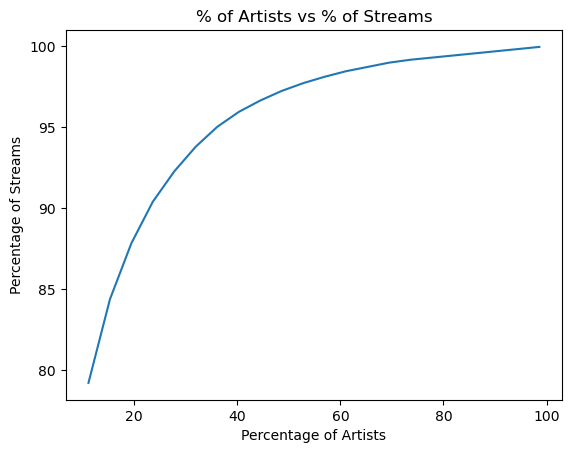

In [531]:
plt.plot(perc_of_artists_list , perc_of_listens_list )
plt.xlabel("Percentage of Artists")
plt.ylabel("Percentage of Streams")
plt.title("% of Artists vs % of Streams")

Okay so it takes a list of the top 170 arists for us to crack 90% of the listens in Spotify History data.



## Genres of up to the top 170 artists

In [103]:
start = time.time()
top_35_to_170_artists_list = list(df.artist_name.value_counts()[35:170].index)
genre_dictionary = mass_genre_fetch(sp, top_35_to_170_artists_list , df) 

with open("genres_artists_35_to_170.csv", "w" , newline = "") as f: 
    writer = csv.writer(f) 
    writer.writerow(["Artist","Genre"]) 
    for artist , genre in genre_dictionary.items(): 
        writer.writerow([artist,genre])

end = time.time()

print(f"Duration of genre retrieval and csv creation: {(end - start):.2f}")

Duration of genre retrieval and csv creation: 32.25


So that took 32.25 seconds 

`Duration of genre retrieval and csv creation: 32.25`

Only issue now is that I mistakenly overwrote the other genre dictionaries. So if I ever want to get them.


In [104]:
df.head(30)

,ts,track_name,artist_name,album_name,spotify_track_uri,genre
0,2025-01-01 02:27:17+00:00,Appreciation,Benji Blue Bills,Campaign Blue,spotify:track:19O5wyExKoHwZxbhFXMO2d,None
1,2025-01-01 02:30:24+00:00,Spaced Out,Young Nudy,Slimeball,spotify:track:4y3l1Qk130C1ebtgIGxltq,None
2,2025-01-01 02:32:29+00:00,TIFFANY,Benji Blue Bills,TIFFANY,spotify:track:0ckMp5ZvtSgFQkzXpyqLKA,None
3,2025-01-01 02:34:07+00:00,5unna,Homixide Gang,Snotty World (Deluxe),spotify:track:2M1LHRfp0vsJKjKfKxOUx3,rage rap
4,2025-01-01 02:35:35+00:00,Santal 33,Benji Blue Bills,500k Degrees,spotify:track:3uHVUXDiDnMoatRNlpNFHd,None
5,2025-01-01 02:37:59+00:00,Demon,Slimesito,Rich slime,spotify:track:2xJmYa4PaiZPhUzEeQdXJw,underground hip hop
6,2025-01-01 04:39:47+00:00,Dirty Opps,Benji Blue Bills,Campaign Blue,spotify:track:2RbFvUcw31WhSif9MgeW3c,None
7,2025-01-01 04:41:25+00:00,SSN,Homixide Gang,SSN,spotify:track:63tCTmZxknDTZKEEEu9JOS,rage rap
8,2025-01-01 04:43:54+00:00,Wat We 5tarted,Benji Blue Bills,Wat We 5tarted,spotify:track:3zB4cvjs2sJ6FrBmfVZB1v,None
9,2025-01-01 09:32:12+00:00,AP Skelly,KANKAN,AP Skelly,spotify:track:5vkaP9pimTrWNd1C0bSk3W,NaN


In [105]:
n = "Benji Blue Bills"
df.loc[df["artist_name"] == n, "genre"] = "rage rap" #place the genre in all rows that the artist appears in
df[df["artist_name"] == n ].head(30)

,ts,track_name,artist_name,album_name,spotify_track_uri,genre
0,2025-01-01 02:27:17+00:00,Appreciation,Benji Blue Bills,Campaign Blue,spotify:track:19O5wyExKoHwZxbhFXMO2d,rage rap
2,2025-01-01 02:32:29+00:00,TIFFANY,Benji Blue Bills,TIFFANY,spotify:track:0ckMp5ZvtSgFQkzXpyqLKA,rage rap
4,2025-01-01 02:35:35+00:00,Santal 33,Benji Blue Bills,500k Degrees,spotify:track:3uHVUXDiDnMoatRNlpNFHd,rage rap
6,2025-01-01 04:39:47+00:00,Dirty Opps,Benji Blue Bills,Campaign Blue,spotify:track:2RbFvUcw31WhSif9MgeW3c,rage rap
8,2025-01-01 04:43:54+00:00,Wat We 5tarted,Benji Blue Bills,Wat We 5tarted,spotify:track:3zB4cvjs2sJ6FrBmfVZB1v,rage rap
16,2025-01-01 09:49:30+00:00,Out of Bounds,Benji Blue Bills,Campaign Blue,spotify:track:49RkcmelPjEoUIf02ONcRN,rage rap
25,2025-01-01 10:09:06+00:00,Leaving LA,Benji Blue Bills,Campaign Blue,spotify:track:3vaDvqkjT93IV1VC5BJFI5,rage rap
58,2025-01-01 12:05:40+00:00,Wat We 5tarted,Benji Blue Bills,Wat We 5tarted,spotify:track:3zB4cvjs2sJ6FrBmfVZB1v,rage rap
67,2025-01-01 12:33:35+00:00,Dirty Opps,Benji Blue Bills,Campaign Blue,spotify:track:2RbFvUcw31WhSif9MgeW3c,rage rap
68,2025-01-01 12:35:53+00:00,Appreciation,Benji Blue Bills,Campaign Blue,spotify:track:19O5wyExKoHwZxbhFXMO2d,rage rap


In [109]:
int(df["genre"].value_counts().values.sum())

19800

In [110]:
df.to_csv("df_90perc_genres.csv", index = False)

### Genres Donut Plot

In [218]:
top5_genres = df["genre"].value_counts().index.tolist()[:5]
top5_genres
top5_genres_counts = df["genre"].value_counts().nlargest(5).values.tolist()
top5_genres_counts

[11090, 2955, 1635, 1227, 624]

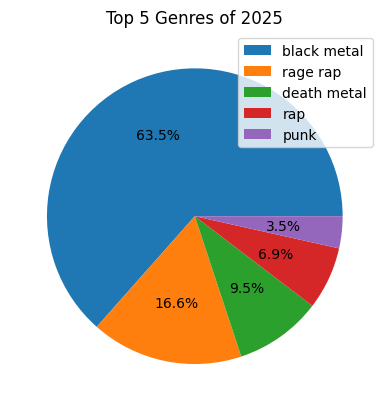

In [79]:
pie = df['genre'].value_counts().nlargest(5).plot(
    kind='pie',
    autopct='%1.1f%%',
    legend=True,
    labels=None
)
plt.title('Top 5 Genres of 2025')
plt.ylabel('')
plt.savefig('pie_top5_genres.png')
plt.show()

### Get album art (For top 10 Albums) 
We'll only do this for the top 10 - 20 artists. The others will have NaN or `'None'` as their entry for `album_art`. 

In [348]:
len(df[df["artist_name"] == "Greta"])

48

In [133]:
df.loc[df["genre"].isin(["german pop"])]

,ts,track_name,artist_name,album_name,spotify_track_uri,genre
5722,2025-03-25 14:13:43+00:00,Fathom,Greta,No Biting,spotify:track:53M6HombmleUN6AF0Ptmgg,german pop
5723,2025-03-25 14:16:30+00:00,School On Fire,Greta,No Biting,spotify:track:3yVfnZDUj0ArrPD9mt2Yyv,german pop
5724,2025-03-25 14:20:08+00:00,Dirtbag,Greta,No Biting,spotify:track:6p00h40LgvW1Q1c97eLFgd,german pop
5725,2025-03-25 14:24:13+00:00,Is It What You Wanted,Greta,No Biting,spotify:track:2gSFZnIrUnUpJRxbcIrIe8,german pop
5726,2025-03-25 14:27:34+00:00,Off The Slug,Greta,No Biting,spotify:track:0t4YgTlNj8imVgorcB3IEv,german pop
5727,2025-03-25 14:31:21+00:00,Revolver,Greta,No Biting,spotify:track:0h8PIbcmBWj99FGrjYmRxQ,german pop
5728,2025-03-25 14:35:14+00:00,Sleepyhead,Greta,No Biting,spotify:track:2PzzDzbbWDTsbWrtB1NTLN,german pop
5729,2025-03-25 14:40:04+00:00,Jesus Crux,Greta,No Biting,spotify:track:1l1rIu7Sqyd0XSD5Gt2mTi,german pop
5730,2025-03-25 14:50:53+00:00,Nature,Greta,No Biting,spotify:track:4pQWK2gQHEq7dF4sehtTV6,german pop
5898,2025-03-26 11:26:18+00:00,Fathom,Greta,No Biting,spotify:track:53M6HombmleUN6AF0Ptmgg,german pop


Here we can see a clear error. Listen to the first 30 seconds of [this song](https://open.spotify.com/track/53M6HombmleUN6AF0Ptmgg?si=7e962a09ea054051) and tell me if this band sounds like they make german pop. Spoiler: They do not. They are a 90's grunge band. 

Greta has one of those Spotify profiles that hosts music from different artists that have the same name. I imagine that is where the "german pop" comes from 

At the very least, all of the genres in the list sound like things I would listen to. 

In [203]:
df.loc[df["artist_name"] == "Greta", "genre"] = "grunge"

In [138]:
questionable_genres = ["bedroom pop","riot grrrl" , "space rock"]
df.loc[df["genre"].isin(["space rock"])]

,ts,track_name,artist_name,album_name,spotify_track_uri,genre
5616,2025-03-25 00:14:05+00:00,Sagadraga,Power Pill Fist,Kongmanivong,spotify:track:6gKVjZTgkiZphKra8pgyOX,space rock
5617,2025-03-25 00:16:41+00:00,Fisticus,Power Pill Fist,Kongmanivong,spotify:track:4h9hAgx8HwSHsmFMQTEKQi,space rock
5618,2025-03-25 00:19:32+00:00,Vile,Power Pill Fist,Kongmanivong,spotify:track:49P1lBgwuiQiFyA1jLRMHP,space rock
5642,2025-03-25 03:17:01+00:00,Vile,Power Pill Fist,Kongmanivong,spotify:track:49P1lBgwuiQiFyA1jLRMHP,space rock
5695,2025-03-25 12:38:52+00:00,"Yff, Lou Pappans",Power Pill Fist,Kongmanivong,spotify:track:4ncV8cTQYGvzr9Th7JXEdM,space rock
5696,2025-03-25 12:41:05+00:00,Sagadraga,Power Pill Fist,Kongmanivong,spotify:track:6gKVjZTgkiZphKra8pgyOX,space rock
5697,2025-03-25 12:43:42+00:00,Fisticus,Power Pill Fist,Kongmanivong,spotify:track:4h9hAgx8HwSHsmFMQTEKQi,space rock
5698,2025-03-25 12:46:33+00:00,Vile,Power Pill Fist,Kongmanivong,spotify:track:49P1lBgwuiQiFyA1jLRMHP,space rock
5699,2025-03-25 12:48:15+00:00,Man Ribbon,Power Pill Fist,Kongmanivong,spotify:track:6BdGLKNc2DV5EUIdPQluin,space rock
5700,2025-03-25 12:51:45+00:00,"Honey, Stroke My Neck Beard",Power Pill Fist,Kongmanivong,spotify:track:4USBVwoNPkj6sNJkIu169N,space rock


Artists with genre : 
*  `None` : Means our function was unable to retrieve a genre for them
*   `NaN` / Null : Our function was never used to retrieve their genre 

In [144]:
#albums_dict = mass_album_art_fetch(sp, top10_albums , df)

artists_no_genre = list(df.loc[df["genre"].isin([None]) , "artist_name"].unique())
artists_no_genre

['Young Nudy',
 'Criminel Kalash',
 'LAZER DIM 700',
 'Nino Andretti',
 'Relivelli',
 'Lil Gotit',
 'mizanicri',
 'Peewee Longway',
 'lilworld5l',
 'Rio Da Yung Og',
 'Jojinooo',
 'KrispyLife Kidd',
 'Akvan',
 'Aria']

In [149]:
df.loc[df["artist_name"] == "Young Nudy","genre"] = "rap"
df.loc[df["artist_name"] == "Young Nudy" ,"genre"] 

1        rap
465      rap
466      rap
467      rap
468      rap
        ... 
15537    rap
15682    rap
15733    rap
16563    rap
20040    rap
Name: genre, Length: 416, dtype: object

In [171]:
index_rap = [1,2,5,7,9,11]
for x in index_rap : 
    print (artists_no_genre[x])
    
#rap_artist_genre_none = artists_no_genre[1:2] + artists_no_genre[5] + artists_no_genre[7] + artist

Nino Andretti
Relivelli
Jojinooo


IndexError: list index out of range

In [158]:
index_rap = [1,2,5,7,9,11]
rap_artists_none_genre = list()
for x in index_rap : 
    rap_artists_none_genre.append(artists_no_genre[x])

rap_artists_none_genre

['LAZER DIM 700',
 'Lil Gotit',
 'Peewee Longway',
 'Rio Da Yung Og',
 'KrispyLife Kidd']

In [161]:
df.loc[df["artist_name"].isin(rap_artists_none_genre),"genre"] = "rap"
df.loc[df["artist_name"].isin(rap_artists_none_genre)]

,ts,track_name,artist_name,album_name,spotify_track_uri,genre
14,2025-01-01 09:44:49+00:00,Greg Heffley,LAZER DIM 700,Greg Heffley,spotify:track:7uXvlUWZjJBr1j5sBVIk5D,rap
32,2025-01-01 10:26:30+00:00,Resident Evil,LAZER DIM 700,Resident Evil,spotify:track:1KUTerytyTUTyM3yE8YOul,rap
156,2025-01-02 20:32:52+00:00,Let's Go (feat. Guap Tarantino),Lil Gotit,Hood Baby,spotify:track:00VSzx7WKMo58bhPDS3HEP,rap
218,2025-01-03 14:24:25+00:00,Resident Evil,LAZER DIM 700,Resident Evil,spotify:track:1KUTerytyTUTyM3yE8YOul,rap
373,2025-01-05 14:15:45+00:00,Beat Da Pack Out,Peewee Longway,The Blue M&M 2 (King Size),spotify:track:0okAMUkh19LQ0zqAKSXAKM,rap
...,...,...,...,...,...,...
17920,2025-08-19 19:52:23+00:00,Resident Evil,LAZER DIM 700,Resident Evil,spotify:track:1KUTerytyTUTyM3yE8YOul,rap
17929,2025-08-19 20:17:12+00:00,Harri & Loyd,Rio Da Yung Og,Dumb and Dumb3r,spotify:track:3Fd7Gp3Fkrjyx9ZDM4rwtt,rap
17937,2025-08-19 20:38:14+00:00,Energy Pt. 2 (feat. Ysr Gramz),KrispyLife Kidd,Ricky Killer,spotify:track:6qXiZe3UWcEPWQEPGMrnku,rap
20038,2025-09-19 14:09:40+00:00,Mismatch (feat. Lil Duke),Lil Gotit,Hood Baby,spotify:track:6Wa2D4pKphSFulN9jcdhBi,rap


In [165]:
df.loc[df["artist_name"] == "Akvan","genre"] = "black metal"
df.loc[df["artist_name"] == "Aria","genre"] = "heavy metal"

In [168]:
artists_no_genre = list(df.loc[df["genre"].isin([None]) , "artist_name"].unique())
artists_no_genre

['Criminel Kalash',
 'Nino Andretti',
 'Relivelli',
 'mizanicri',
 'lilworld5l',
 'Jojinooo']

In [170]:
rage_artists_no_genre = artists_no_genre[1:5]
rage_artists_no_genre

['Nino Andretti', 'Relivelli', 'mizanicri', 'lilworld5l']

In [172]:
df.loc[df["artist_name"].isin(rage_artists_no_genre),"genre"] = "rage rap"

In [173]:
artists_no_genre = list(df.loc[df["genre"].isin([None]) , "artist_name"].unique())
artists_no_genre

['Criminel Kalash', 'Jojinooo']

In [174]:
df.loc[df["artist_name"].isin(artists_no_genre),"genre"] = "rap"

In [175]:
artists_no_genre = list(df.loc[df["genre"].isin([None]) , "artist_name"].unique())
artists_no_genre

[]

### Export another dictionary with all artists and their genres 

In [184]:
df["genre"].isnull().value_counts()
df["genre"].value_counts()

genre
black metal            11090
rage rap                2955
death metal             1635
rap                     1227
punk                     624
hardcore punk            492
jangle pop               428
melodic rap              301
dream pop                288
speed metal              226
thrash metal             209
chillwave                123
psychedelic rock         120
skate punk                88
underground hip hop       86
chicago drill             82
bedroom pop               51
german pop                48
shoegaze                  46
grunge                    42
indie                     37
cloud rap                 35
riot grrrl                34
pop punk                  34
ambient folk              33
horror punk               28
neo-psychedelic           27
space rock                26
melodic death metal       25
progressive rock          24
heavy metal               23
art pop                   21
brooklyn drill            20
surf rock                 20
dark amb

In [194]:
genres_dict_90perc = dict()
artists_w_genre_list = list(df.loc[df["genre"].isnull() == False ,"artist_name"].unique())
artists_w_genre_list
len(artists_w_genre_list)

170

In [343]:
artists = df["artist_name"].unique()
len(artists)

720

In [193]:
artists_wo_genre_list = list(df.loc[df["genre"].isnull(),"artist_name"].unique())
len(artists_wo_genre_list)

550

This adds up given that we only attempted to retrieve the genres for the first 170 most listened to artists. We have 720 artists in our dataframe , and 550 of them have a null value for their genre. Lets export our completed list of the 170 artists' genres into a csv. 

In [197]:
list(df.loc[df["artist_name"] == x , "genre"].unique())[0]

'rap'

In [204]:
genres_dict_top170 = dict()

for x in artists_w_genre_list: 
    genres_dict_top170[x] = list(df.loc[df["artist_name"] == x , "genre"].unique())[0]

len(genres_dict_top170)

170

In [205]:
with open("genres_artists_top170.csv", "w" , newline = "") as f: 
    writer = csv.writer(f) 
    writer.writerow(["Artist","Genre"]) 
    for artist , genre in genres_dict_top170.items(): 
        writer.writerow([artist,genre])

## Fetching the Album Art for my Top 20 Albums of 2025

Lets get album art URLs for the top 10 (or possibly 20) albums before we try fetching anymore genres

In [211]:
def get_album_art(sp, track_uri): 
    track = sp.track(track_uri)
    image_urls =  track['album']["images"]
    if len(image_urls) >= 2 :
        album_art_url = image_urls[-2]["url"] # 2nd to smallest size
    else: 
        album_art_url = image_urls[0]["url"]
    return album_art_url

In [212]:
def mass_album_art_fetch(sp, album_list,df): 
    """Retrieves url for album art, stores in dataframe, returns dictionary of album art urls"""
    album_dict = dict() 
    
    for x in album_list : 
        df_albums = df[df["album_name"] == x ]
        row_0 = next(df_albums.itertuples(index=False))
        album_art_url = get_album_art(sp, row_0.spotify_track_uri)
        df.loc[df["album_name"] == x, "album_art_url"] = album_art_url #place the genre in all rows that the artist appears in
        album_dict[x] = album_art_url
    return album_dict 

In [121]:
what_we_started_art = get_album_art(sp,'spotify:track:3zB4cvjs2sJ6FrBmfVZB1v')
what_we_started_art

'https://i.scdn.co/image/ab67616d00001e02667db8ddb394b4abeac73549'

In [213]:
#albums_dict = mass_album_art_fetch(sp, top10_albums , df)
top20_albums_listens = df.album_name.value_counts().nlargest(20)
top20_albums_listens
top20_albums = list(top20_albums_listens.index)
top20_albums

['Antichrist Rise to Power',
 'The Somberlain',
 'Only True Believers',
 '4L',
 'FRIEND OR FOUX',
 'The Final War Approaching',
 'Across The Open Sea',
 'Høstmørke',
 'Dethroned, Conquered and Forgotten',
 'Nudy Land',
 'Nachthymnen/Orkblut-The Retaliation',
 'Pure Holocaust',
 'Under the Sign of the Black Mark',
 'Satan Soldier of Fortune',
 'Under A Funeral Moon',
 "Reagan's In",
 'A Blaze In The Northern Sky',
 '2 Alivë',
 'Battles in the North',
 'Nattferd']

In [214]:
start = time.time()
albums_dict = mass_album_art_fetch(sp, top20_albums , df)
end = time.time()
print(f"Top 20 Album covers fetched in :{end - start:.2f} seconds")
albums_dict

Top 20 Album covers fetched in :2.97 seconds


{'Antichrist Rise to Power': 'https://i.scdn.co/image/ab67616d00001e022acc0f1ce06a295cd2661dc9',
 'The Somberlain': 'https://i.scdn.co/image/ab67616d00001e02a71b7074f0f4b217e303fd20',
 'Only True Believers': 'https://i.scdn.co/image/ab67616d00001e024cf8544e64841bf8f44eab00',
 '4L': 'https://i.scdn.co/image/ab67616d00001e022a2ca1ad79dd181c31e08c81',
 'FRIEND OR FOUX': 'https://i.scdn.co/image/ab67616d00001e026c13dd486dfa99262a3dc919',
 'The Final War Approaching': 'https://i.scdn.co/image/ab67616d00001e02c5e4cb2f692ba3776a1fd1b0',
 'Across The Open Sea': 'https://i.scdn.co/image/ab67616d00001e022e9ff8ef7b4ea158189aa43c',
 'Høstmørke': 'https://i.scdn.co/image/ab67616d00001e02edf168d3ae6c4369374f2a42',
 'Dethroned, Conquered and Forgotten': 'https://i.scdn.co/image/ab67616d00001e02e26b2c84969e2db459eea017',
 'Nudy Land': 'https://i.scdn.co/image/ab67616d00001e023c6ebc51dba29a2cef992c6e',
 'Nachthymnen/Orkblut-The Retaliation': 'https://i.scdn.co/image/ab67616d00001e02643294187c01043b0c4b

In [216]:
df[df["album_art_url"].isnull() == False]

,ts,track_name,artist_name,album_name,spotify_track_uri,genre,album_art_url
10,2025-01-01 09:35:21+00:00,Forëally / 4Ly,Yeat,4L,spotify:track:1aztkqMhtL4XSuGASmEeCo,rage rap,https://i.scdn.co/image/ab67616d00001e022a2ca1...
11,2025-01-01 09:37:58+00:00,Chanëlly,Yeat,4L,spotify:track:2FRKyoQdvr86WJiMZxX2J7,rage rap,https://i.scdn.co/image/ab67616d00001e022a2ca1...
20,2025-01-01 09:58:30+00:00,WTF,Yeat,4L,spotify:track:4mqsffIsjada5FIbI6cuNJ,rage rap,https://i.scdn.co/image/ab67616d00001e022a2ca1...
31,2025-01-01 10:24:48+00:00,Nvr again,Yeat,2 Alivë,spotify:track:4J7IUiMAbCEBN15c2ekiDh,rage rap,https://i.scdn.co/image/ab67616d00001e0272b69f...
33,2025-01-01 10:30:17+00:00,Narcoticz (feat. Yung Kayo),Yeat,2 Alivë,spotify:track:6j1FxJKgxzP11CGXycjT0s,rage rap,https://i.scdn.co/image/ab67616d00001e0272b69f...
...,...,...,...,...,...,...,...
22659,2025-10-28 11:03:02+00:00,Unholy Sacrifice,Armagedda,The Final War Approaching,spotify:track:6G4KwOR00jKmTt16jAaOpE,black metal,https://i.scdn.co/image/ab67616d00001e02c5e4cb...
22663,2025-10-28 11:18:14+00:00,"Benevolent Whore, Dethroned for Eternity",Judas Iscariot,"Dethroned, Conquered and Forgotten",spotify:track:109TdNFiWLmfnrJOiK9rif,black metal,https://i.scdn.co/image/ab67616d00001e02e26b2c...
22738,2025-10-29 15:40:07+00:00,Journey Through Visions of War,Judas Iscariot,"Dethroned, Conquered and Forgotten",spotify:track:4GK0Xok6iY2R58hZESY09e,black metal,https://i.scdn.co/image/ab67616d00001e02e26b2c...
22739,2025-10-29 15:44:56+00:00,Descent to the Abyss,Judas Iscariot,"Dethroned, Conquered and Forgotten",spotify:track:7cIyZddQetBH98hy7pgZvP,black metal,https://i.scdn.co/image/ab67616d00001e02e26b2c...


In [221]:
len(df)

22749

In [299]:
x = 20 
albums_list = list(df["album_name"].unique())
albums_freq_list = list() 
perc_of_albums_list = list() # to be used in a dataframe --> plot , X
perc_of_listens_by_albums_list = list() # to be used in a dataframe --> line chart , Y = f(X)  


while x < (len(albums_list)): 
    
    top_albums_list = list(df.album_name.value_counts()[:x].index)
    albums_freq_list.append(len(top_albums_list)) 
    
    top_albums_frequency = int(df["album_name"].isin(top_albums_list).sum()) #the total quantity of times our current selection of albums (quantity = x) appear in our dataframe 
    top_albums_percentage = (top_albums_frequency / len(df) ) * 100 #percentage of total listens/streams that corresponds to our current album count (x) 
    total_albums_count = len(df["album_name"].unique())
    perc_of_albums = (len(top_albums_list) / total_albums_count) * 100 #current percentage of albums
    perc_of_albums_list.append(perc_of_albums) 
    perc_of_listens_by_albums_list.append(top_albums_percentage) # the list of percentages of total streams that correspond to each given quantity of albums (x) 
    
    print(f"{len(top_albums_list)} albums account for {top_albums_percentage:.2f} % of my listens.\n")
    print(f"{perc_of_albums:.2f}% of my albums account for {top_albums_percentage:.2f} % of my listens.\n")
    print("______________________________________")
    x = x + 20 
    if top_albums_percentage >= 99.00 : 
        break

20 albums account for 26.02 % of my listens.

1.48% of my albums account for 26.02 % of my listens.

______________________________________
40 albums account for 40.90 % of my listens.

2.97% of my albums account for 40.90 % of my listens.

______________________________________
60 albums account for 50.90 % of my listens.

4.45% of my albums account for 50.90 % of my listens.

______________________________________
80 albums account for 58.05 % of my listens.

5.93% of my albums account for 58.05 % of my listens.

______________________________________
100 albums account for 62.87 % of my listens.

7.41% of my albums account for 62.87 % of my listens.

______________________________________
120 albums account for 66.58 % of my listens.

8.90% of my albums account for 66.58 % of my listens.

______________________________________
140 albums account for 69.80 % of my listens.

10.38% of my albums account for 69.80 % of my listens.

______________________________________
160 albums accou

In [234]:
for x in range(0,len(perc_of_albums_list)): 
    perc_of_albums_list[x] = x/100
    

len(perc_of_albums_list)

57

Text(0.5, 1.0, '% of Albums vs % of Streams')

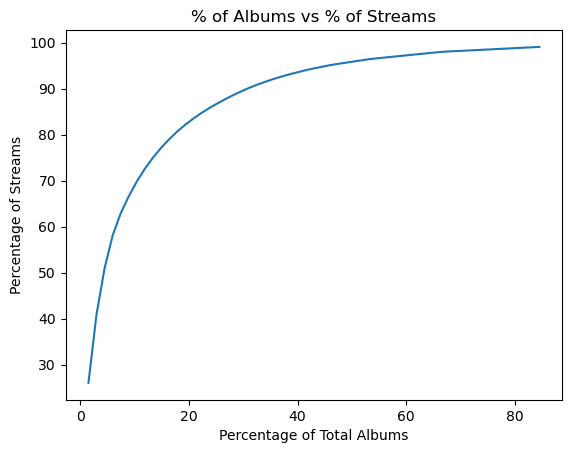

In [289]:
plt.plot(perc_of_albums_list ,perc_of_listens_by_albums_list   )
plt.xlabel("Percentage of Total Albums")
plt.ylabel("Percentage of Streams")
plt.title("% of Albums vs % of Streams")

In [241]:
df.to_csv("df_ninety_perc_genres.csv", index = False)

### Processing Dates: Seasons Feature 
We will create a season feature for our dataframe

In [252]:
def get_season(date): 
    date_no_time = dt.datetime.strptime(date, "%Y-%m-%d")
    month = date_no_time.month
    
    if month in [12,1,2]: 
        return "Winter"
    elif month in [3,4,5]: 
        return "Spring"
    elif month in [6,7,8]: 
        return "Summer" 
    elif month in [9,10,11]: 
        return "Autumn" 

In [267]:
for x in df["ts"]: 
    df.loc[df["ts"] == x , "season"] = get_season(str(x)[:10]) #slicing is not the best workaround for excluding time 

In [268]:
df

,ts,track_name,artist_name,album_name,spotify_track_uri,genre,album_art_url,season
0,2025-01-01 02:27:17+00:00,Appreciation,Benji Blue Bills,Campaign Blue,spotify:track:19O5wyExKoHwZxbhFXMO2d,rage rap,NaN,Winter
1,2025-01-01 02:30:24+00:00,Spaced Out,Young Nudy,Slimeball,spotify:track:4y3l1Qk130C1ebtgIGxltq,rap,NaN,Winter
2,2025-01-01 02:32:29+00:00,TIFFANY,Benji Blue Bills,TIFFANY,spotify:track:0ckMp5ZvtSgFQkzXpyqLKA,rage rap,NaN,Winter
3,2025-01-01 02:34:07+00:00,5unna,Homixide Gang,Snotty World (Deluxe),spotify:track:2M1LHRfp0vsJKjKfKxOUx3,rage rap,NaN,Winter
4,2025-01-01 02:35:35+00:00,Santal 33,Benji Blue Bills,500k Degrees,spotify:track:3uHVUXDiDnMoatRNlpNFHd,rage rap,NaN,Winter
...,...,...,...,...,...,...,...,...
22744,2025-10-29 19:11:53+00:00,Crying for Death,Morbid Saint,Spectrum of Death,spotify:track:49vQZiDk1YfTtNb04MY6jr,thrash metal,NaN,Autumn
22745,2025-10-29 19:15:01+00:00,Andanom,Wulkanaz,Wulkanaz,spotify:track:1K2Uu3SUF5ftqxqidoLVEo,black metal,NaN,Autumn
22746,2025-10-29 19:28:49+00:00,Crush the Skull,Unleashed,Shadows in the Deep,spotify:track:6DdtUqruR9qAaQY6IU9YG2,death metal,NaN,Autumn
22747,2025-10-29 19:33:08+00:00,Bitter Loss,Entombed,Left Hand Path,spotify:track:7cjxGM8tECsRdiTBYc2KFw,death metal,NaN,Autumn


In [261]:
s = "2025-01-01 02:27:17+00:00"

dt.datetime.strptime(s[:10], "%Y-%m-%d")

datetime.datetime(2025, 1, 1, 0, 0)

## Fetching the Remaining Genres 

As many of the remaining genres as possible. Since I am okay with missing the genres for around 5% of my streams. I think I will settle with getting the genres for the top 260 artists in my dataframe. If you recall earlier: 

> ______________________________________
> 260 artists account for 95.02 % of my listens.
> 
> 36.11% of my artists account for 95.02 % of my listens.


Here we have to factor in the fact that we will likely run out of API calls while searching for the genres of our 550 remaining artists. 

In [302]:
start = time.time()
top_170_to_260_artists_list = list(df.artist_name.value_counts()[170: 260].index)
genre_dictionary_170_to_260 = mass_genre_fetch(sp, top_170_to_260_artists_list ,df) 

with open("genres_artists_170_to_260.csv", "w" , newline = "") as f: 
    writer = csv.writer(f) 
    writer.writerow(["Artist","Genre"]) 
    for artist , genre in genre_dictionary_170_to_260.items(): 
        writer.writerow([artist,genre])

end = time.time()

print(f"Duration of genre retrieval and csv creation: {(end - start):.2f}")

Duration of genre retrieval and csv creation: 24.24


In [303]:
df["genre"].isnull().value_counts()

genre
False    21379
True      1370
Name: count, dtype: int64

In [304]:
1370/21379

0.06408157537770709

In [167]:
df.to_csv("df_95perc_genres_top20_albums_seasons.csv", index = "False")

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22749 entries, 0 to 22748
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   ts                 22749 non-null  datetime64[ns, UTC]
 1   track_name         22748 non-null  object             
 2   artist_name        22748 non-null  object             
 3   album_name         22748 non-null  object             
 4   spotify_track_uri  22748 non-null  object             
 5   genre              21379 non-null  object             
 6   album_art_url      6113 non-null   object             
 7   season             22749 non-null  object             
dtypes: datetime64[ns, UTC](1), object(7)
memory usage: 1.4+ MB


In [308]:
df.loc[df["album_name"] == "The Black Crest of Death, The Gold Wreath of War" , "album_art_url"] = get_album_art(sp,'spotify:track:44ps4XL3yOHNYguUe80yB0')

In [307]:
bcd_gww = get_album_art(sp,'spotify:track:44ps4XL3yOHNYguUe80yB0')
bcd_gww

'https://i.scdn.co/image/ab67616d00001e027576cbb23bb611e042408722'

In [309]:
df.loc[df["album_name"] == "The Black Crest of Death, The Gold Wreath of War" , "album_art_url"]

8927     https://i.scdn.co/image/ab67616d00001e027576cb...
8928     https://i.scdn.co/image/ab67616d00001e027576cb...
8929     https://i.scdn.co/image/ab67616d00001e027576cb...
8933     https://i.scdn.co/image/ab67616d00001e027576cb...
9018     https://i.scdn.co/image/ab67616d00001e027576cb...
                               ...                        
21804    https://i.scdn.co/image/ab67616d00001e027576cb...
22075    https://i.scdn.co/image/ab67616d00001e027576cb...
22076    https://i.scdn.co/image/ab67616d00001e027576cb...
22077    https://i.scdn.co/image/ab67616d00001e027576cb...
22407    https://i.scdn.co/image/ab67616d00001e027576cb...
Name: album_art_url, Length: 193, dtype: object

In [310]:
df.to_csv("df_95perc_genres_top20_albums_seasons.csv", index = "False")

In [4]:
import calendar

In [5]:
months = list(calendar.month_name)
months

['',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [7]:
months.pop(0)
months

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [39]:
import calendar

months = list(calendar.month_name[1:11])

artists_month = dict()

for x,y in zip(range(1,11) ,months): 
    top_artist = df.loc[df["ts"].dt.month == x , "artist_name"].value_counts().idxmax()
    artists_month[y] = top_artist

In [ ]:
df_months = pd.DataFrame.from_dict(artists_month , orient="Index", columns= ["top_artist"])
df_months

In [173]:
df_months.to_csv("df_top_artist_per_month.csv", index=True)

In [163]:
seasons = ["Winter","Spring", "Summer","Autumn"]
artist_per_season = dict()

for x in seasons: 
    season_artist = df.loc[df["season"] == x , "artist_name"].value_counts().idxmax()
    artist_per_season[x] = season_artist 
    
artist_per_season

{'Winter': 'Yeat',
 'Spring': 'Unleashed',
 'Summer': 'Armagedda',
 'Autumn': 'Wagner Ödegård'}

In [148]:
genre_per_season = dict() 

for x in seasons: 
    season_genre = df.loc[df["season"] == x , "genre"].value_counts().idxmax()
    genre_per_season[x] = season_genre

genre_per_season

{'Winter': 'rage rap',
 'Spring': 'black metal',
 'Summer': 'black metal',
 'Autumn': 'black metal'}

## Busiest streaming hour of the day



In [34]:
df_days_hours = pd.DataFrame(data = df["ts"] ,  columns = ["ts", "day" , "hour" ] )
df_days_hours

,ts,day,hour
0,2025-01-01 02:27:17+00:00,NaN,NaN
1,2025-01-01 02:30:24+00:00,NaN,NaN
2,2025-01-01 02:32:29+00:00,NaN,NaN
3,2025-01-01 02:34:07+00:00,NaN,NaN
4,2025-01-01 02:35:35+00:00,NaN,NaN
...,...,...,...
22744,2025-10-29 19:11:53+00:00,NaN,NaN
22745,2025-10-29 19:15:01+00:00,NaN,NaN
22746,2025-10-29 19:28:49+00:00,NaN,NaN
22747,2025-10-29 19:33:08+00:00,NaN,NaN


In [209]:
df_days_hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22749 entries, 0 to 22748
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         22749 non-null  int64 
 1   ts                 22749 non-null  object
 2   track_name         22748 non-null  object
 3   artist_name        22748 non-null  object
 4   album_name         22748 non-null  object
 5   spotify_track_uri  22748 non-null  object
 6   genre              21379 non-null  object
 7   album_art_url      6113 non-null   object
 8   season             22749 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.6+ MB


In [8]:
df_days_hours = df.copy()
df_days_hours["day_ind"] = df_days_hours["ts"].dt.day_of_year
df_days_hours["hour_ind"] = df_days_hours["ts"].dt.hour
df_days_hours["month"] = df_days_hours["ts"].dt.month


#keep the relevant columns 
cols_list = df_days_hours.columns.tolist()
cols = cols_list[:1] + cols_list[8:11]

df_days_hours = df_days_hours[cols]
df_days_hours

,ts,day_ind,hour_ind,month
0,2025-01-01 02:27:17+00:00,1,2,1
1,2025-01-01 02:30:24+00:00,1,2,1
2,2025-01-01 02:32:29+00:00,1,2,1
3,2025-01-01 02:34:07+00:00,1,2,1
4,2025-01-01 02:35:35+00:00,1,2,1
...,...,...,...,...
22744,2025-10-29 19:11:53+00:00,302,19,10
22745,2025-10-29 19:15:01+00:00,302,19,10
22746,2025-10-29 19:28:49+00:00,302,19,10
22747,2025-10-29 19:33:08+00:00,302,19,10


In [9]:
for x in df_days_hours["month"]:
    df_days_hours.loc[df_days_hours["month"] == int(x) ,"month_name"] = calendar.month_name[x]

df_days_hours.tail()

,ts,day_ind,hour_ind,month,month_name
22744,2025-10-29 19:11:53+00:00,302,19,10,October
22745,2025-10-29 19:15:01+00:00,302,19,10,October
22746,2025-10-29 19:28:49+00:00,302,19,10,October
22747,2025-10-29 19:33:08+00:00,302,19,10,October
22748,2025-10-29 19:36:25+00:00,302,19,10,October


In [211]:
df_days_hours.tail()

,Unnamed: 0,ts,track_name,artist_name,album_name,spotify_track_uri,genre,album_art_url,season
22744,22744,2025-10-29 19:11:53+00:00,Crying for Death,Morbid Saint,Spectrum of Death,spotify:track:49vQZiDk1YfTtNb04MY6jr,thrash metal,NaN,Autumn
22745,22745,2025-10-29 19:15:01+00:00,Andanom,Wulkanaz,Wulkanaz,spotify:track:1K2Uu3SUF5ftqxqidoLVEo,black metal,NaN,Autumn
22746,22746,2025-10-29 19:28:49+00:00,Crush the Skull,Unleashed,Shadows in the Deep,spotify:track:6DdtUqruR9qAaQY6IU9YG2,death metal,NaN,Autumn
22747,22747,2025-10-29 19:33:08+00:00,Bitter Loss,Entombed,Left Hand Path,spotify:track:7cjxGM8tECsRdiTBYc2KFw,death metal,NaN,Autumn
22748,22748,2025-10-29 19:36:25+00:00,Into Glory Ride,Unleashed,Where No Life Dwells,spotify:track:7oV7uI6LsjW9dZ0iQWjyE8,death metal,NaN,Autumn


In [10]:
busiest_hour_dict = dict() #dictionary that may be imported into a dataframe 
df_busiest_hour = df_days_hours.copy()



days_list = list(range(1,303))


for x in days_list : 
    if len(df_days_hours.loc[df_days_hours["day_ind"] == int(x) , "hour_ind"].value_counts()) > 0 : #if the array of value_counts is non-empty
        max_hour = df_days_hours.loc[df_days_hours["day_ind"] == int(x) , "hour_ind"].value_counts().idxmax() #retrieve the max hour
        busiest_hour_dict[x] = int(max_hour) #assign max hour to it's respective day in the dictionary
        df_days_hours.loc[df_days_hours["day_ind"] == int(x) , "busiest_hour"] =  int(max_hour)
    else: 
       busiest_hour_dict[x] = None #assign none if the value_counts series is empty

In [207]:
df_days_hours.loc[df_days_hours["day_ind"] == 1]

,ts,day_ind,hour_ind,month,month_name,busiest_hour
0,2025-01-01 02:27:17+00:00,1,2,1,January,10.0
1,2025-01-01 02:30:24+00:00,1,2,1,January,10.0
2,2025-01-01 02:32:29+00:00,1,2,1,January,10.0
3,2025-01-01 02:34:07+00:00,1,2,1,January,10.0
4,2025-01-01 02:35:35+00:00,1,2,1,January,10.0
...,...,...,...,...,...,...
86,2025-01-01 23:53:06+00:00,1,23,1,January,10.0
87,2025-01-01 23:55:22+00:00,1,23,1,January,10.0
88,2025-01-01 23:57:20+00:00,1,23,1,January,10.0
89,2025-01-01 23:58:29+00:00,1,23,1,January,10.0


In [181]:
df_days_hours.loc[df_days_hours["day_ind"] == 1, "hour_ind"].value_counts()

hour_ind
10    25
12    17
9     12
11    10
23    10
13     7
2      6
4      3
20     1
Name: count, dtype: int64

In [19]:
df_busiest_hours = df_days_hours[["day_ind" ,"month_name" ,"busiest_hour"]]
df_busiest_hours = df_busiest_hours.drop_duplicates()
df_busiest_hours = df_busiest_hours.set_axis(list(range(0,len(df_busiest_hours))), axis = 0)
df_busiest_hours

,day_ind,month_name,busiest_hour
0,1,January,10.0
1,2,January,0.0
2,3,January,2.0
3,4,January,11.0
4,5,January,17.0
...,...,...,...
257,298,October,0.0
258,299,October,1.0
259,300,October,2.0
260,301,October,16.0


In [43]:
months_list = list(calendar.month_name)[1:11]
months_list
peak_hours_list = list()

for x in months_list: 
    peak_hour = df_busiest_hours.loc[df_busiest_hours["month_name"] == x,"busiest_hour"].value_counts().idxmax()
    peak_hours_list.append(peak_hour)
    print(f"For {x} , the most frequent hour of listening was {peak_hour}.\n")

For January , the most frequent hour of listening was 10.0.

For February , the most frequent hour of listening was 12.0.

For March , the most frequent hour of listening was 12.0.

For April , the most frequent hour of listening was 10.0.

For May , the most frequent hour of listening was 15.0.

For June , the most frequent hour of listening was 11.0.

For July , the most frequent hour of listening was 10.0.

For August , the most frequent hour of listening was 11.0.

For September , the most frequent hour of listening was 9.0.

For October , the most frequent hour of listening was 11.0.



In [55]:
print(f"The average peak streaming hour of 2025 is {int(np.mean(peak_hours_list))}.")

The average peak streaming hour of 2025 is 11.


In [177]:
busiest_hour_dict

{1: 10,
 2: 0,
 3: 2,
 4: 11,
 5: 17,
 6: None,
 7: None,
 8: 18,
 9: 16,
 10: None,
 11: None,
 12: None,
 13: None,
 14: None,
 15: None,
 16: None,
 17: None,
 18: None,
 19: None,
 20: None,
 21: None,
 22: None,
 23: None,
 24: None,
 25: None,
 26: None,
 27: None,
 28: None,
 29: None,
 30: None,
 31: None,
 32: None,
 33: None,
 34: None,
 35: None,
 36: None,
 37: 18,
 38: 12,
 39: 9,
 40: 9,
 41: 12,
 42: 12,
 43: 22,
 44: 12,
 45: 15,
 46: 2,
 47: 12,
 48: 13,
 49: 12,
 50: 14,
 51: 14,
 52: 12,
 53: 21,
 54: 16,
 55: 23,
 56: 12,
 57: 13,
 58: 18,
 59: 16,
 60: 12,
 61: 12,
 62: 16,
 63: 19,
 64: 17,
 65: 20,
 66: 23,
 67: 13,
 68: 0,
 69: 18,
 70: 11,
 71: 14,
 72: 12,
 73: 13,
 74: 15,
 75: 12,
 76: 18,
 77: 10,
 78: 14,
 79: 10,
 80: 10,
 81: 16,
 82: 7,
 83: 11,
 84: 11,
 85: 7,
 86: 12,
 87: 10,
 88: 14,
 89: 15,
 90: 10,
 91: 9,
 92: 11,
 93: 10,
 94: 11,
 95: 14,
 96: 22,
 97: 10,
 98: 12,
 99: 21,
 100: 16,
 101: 10,
 102: 11,
 103: 9,
 104: 9,
 105: 13,
 106: 13,
 

In [111]:
df_busiest_hour = df_days_hours.copy()

for x in df_busiest_hour["day_ind"]: 
    #int(df_busiest_hour.loc[df["day_ind"] == int(x) , "hour_ind"].value_counts().idxmax())
    df_busiest_hour.loc[df_days_hours["day_ind"] == int(x) , "busiest_hour"] =  int(busiest_hour_dict[x])

    
df_busiest_hour

,ts,day_ind,hour_ind,month,month_name,busiest_hour
0,2025-01-01 02:27:17+00:00,1,2,1,January,10.0
1,2025-01-01 02:30:24+00:00,1,2,1,January,10.0
2,2025-01-01 02:32:29+00:00,1,2,1,January,10.0
3,2025-01-01 02:34:07+00:00,1,2,1,January,10.0
4,2025-01-01 02:35:35+00:00,1,2,1,January,10.0
...,...,...,...,...,...,...
22744,2025-10-29 19:11:53+00:00,302,19,10,October,11.0
22745,2025-10-29 19:15:01+00:00,302,19,10,October,11.0
22746,2025-10-29 19:28:49+00:00,302,19,10,October,11.0
22747,2025-10-29 19:33:08+00:00,302,19,10,October,11.0


In [143]:
months_list = list(calendar.month_name)
months_list = months_list[1:11]
months_list

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October']

In [145]:
busiest_hr_per_month_dict= dict()


for x in months_list:
    busiest_hr_per_month = df_busiest_hour.loc[df_busiest_hour["month_name"] == x, "busiest_hour_month"].value_counts().idxmax() #kind of a silly method since the idxmax is the only value in value_counts  
    busiest_hr_per_month_dict[x] = int(busiest_hr_per_month)

busiest_hr_per_month_dict

{'January': 7,
 'February': 14,
 'March': 12,
 'April': 11,
 'May': 10,
 'June': 11,
 'July': 10,
 'August': 10,
 'September': 10,
 'October': 10}

In [157]:
df_busiest_hour_per_month = pd.DataFrame.from_dict(busiest_hr_per_month_dict , columns=["avg_peak_hour"] ,orient = "Index")
df_busiest_hour_per_month

,avg_peak_hour
January,7
February,14
March,12
April,11
May,10
June,11
July,10
August,10
September,10
October,10


In [158]:
df_busiest_hour_per_month.to_csv("busiest_hour_per_month.csv")

## Distribution of streaming hours 

A good portion of my streaming is concentrated around the morning to early afternoon. This aligns with the insights we generated earlier. 11 AM seems to be the most frequent listening hour for 2025. 

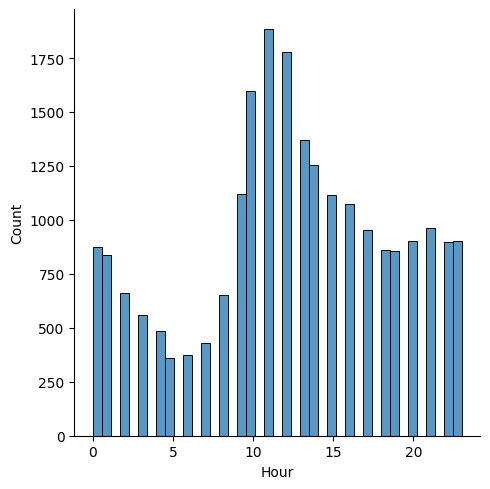

In [4]:
df_hours = df.assign(Hour=df["ts"].dt.hour)
sns.displot(data=df_hours, x="Hour")

In [6]:
df["ts"].dt.hour.skew()

np.float64(-0.24590394565574877)

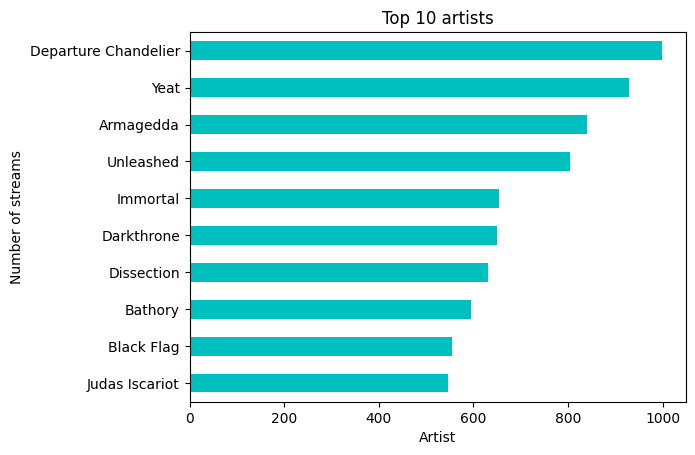

In [28]:
df["artist_name"].value_counts().nlargest(10).plot(kind='barh',
                                                   title='Top 10 artists',
                                                   xlabel = 'Artist',
                                                   ylabel = 'Number of streams',
                                                   color = 'c').invert_yaxis()

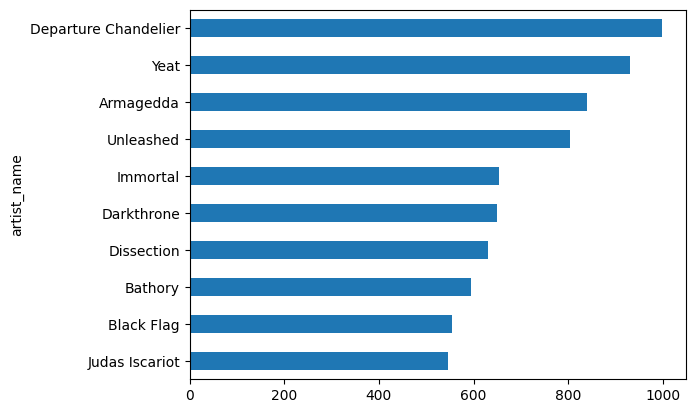